$$\text{Original: }\frac{{dP}}{{dt}} = r_P \cdot P(t) \cdot \left(1 - \frac{{P(t)}}{{K_P}}\right) \cdot \left(\frac{{F(t)}}{{K_F}}\right) - d_P \cdot P(t)$$

$${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})$$

$${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})- d\cdot N$$

$$K_i^{(t+1)} = \max \left(\min \left(K_i^*,K_i^t + k(K_i^*-K_i^t)-u_i^t\right),0\right)$$

$$P_i = \sum_{i} K_i$$

$$K^t = \sum_{i=1}^{M} u_i^t K_i^t$$


$$
u_i^t = \begin{cases}
1, & \text{if rank}(K_i^t) \leq P^t \\
0, & \text{otherwise}
\end{cases}
$$


In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
%pip install -upgrade ipywidgets
clear_output()
#update


### Land Division Situation - One land, one person

 This code is to solve the conflict between the logistic population growth and the constrained food supply.
 What's wrong before?
 $${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})- d\cdot N$$
 Previously, the "find_top_lands" functions find the best min lands just to satisfy the population needs. This becomes the limit of the population growth because $\frac{{N^{(t)}}}{{P}}$ $\approx$ 1 which gives $r$ a very small quota. Therefore, the population growth is very slow. As you can see in my Week 1 work, for all the ranges of the parameters, population all declined and converged to almost 0 in the end.

#### **Solution 1: solve conflict between logistic population growth and the find _top land function using leslie matrix for the population structure.**
In this case, the population growth function is no longer the ${{N^{(t+1)}}} = {{N^{(t)}}} + r\cdot {{N^{(t)}}} (1-\frac{{N^{(t)}}}{{P}})- d\cdot N$. Instead, it is updated each year based on a matrix (the population structure). However, the matrix and the parameters are alreayd set based on the empirical research.

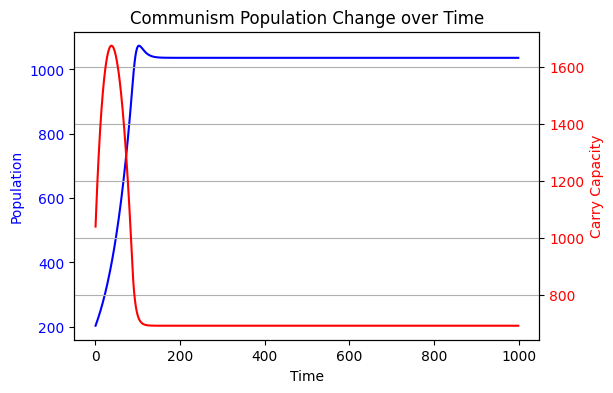

In [108]:
vec1 = pd.read_csv('demog_vectors.csv')
tmp1 = pd.DataFrame({'z': [], 'r': []})  # Initialize an empty DataFrame

# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(tmp1, vec1, k,  a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):

    # Get the Leslie matrix for a given food ratio (z) using the parameters
    def get_matrix(z, vec1):
        p0 = vec1.pstar * sp.gdtr(1.0/vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0/vec1.fertscale[0], vec1.fertparm[0], z)
        N = len(p0)
        m1 = np.zeros([N,N])
        for i in range(N-1):
            m1[i+1,i] = p0[i]
        m1[0,] = m0
        return m1

    # Calculate relative population change in one year for a given food ratio
    def get_rate(z, vec1):
        m1 = get_matrix(z, vec1)
        tmp2 = sl.eigvals(m1)
        ix = tmp2.real.argmax()
        if tmp2[ix].imag != 0.0:
            raise BaseException('Invalid solution!\n')
        return tmp2[ix].real
         
    ### d is natural death rate    
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_population): 
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': i, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_population)] 
    
    ### Farming Process
        ### Define the function
        
    def find_top_lands(K_t, populations): 
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
        cumulative_utility = 0
        selected_lands = []
                
        for land_index, utility in sorted_lands:
            cumulative_utility += utility
            selected_lands.append(land_index)  
            if cumulative_utility >= populations[-1]:
                break

        if len(selected_lands) > populations[-1]:
            selected_lands = selected_lands[:int(populations[-1].astype(float))] ####corrected
        else: pass
        return selected_lands
   
    ### Updating process
        
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_population)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = find_top_lands(K_t, populations) # select top lands in each year
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_population): 
                land_assignments[t][i] = {
                    'landlord': i,
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }

        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
   
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_population)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
            
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(initial_population):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * land_assignments[t-1][i]['carry_capacity'] * u_t[i])) ############
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_population)] ## list of each land cell capacity (new year, this year)

        # Calculate the Leslie matrix for the current food ratio (z)
        z = P/ N_t  # food availability parameter == carry capacity in my case 
        ### in the original code file, Y - scalar, kcal/ha/day in ag yield - it is a constant (?) only one value.
        m1 = get_matrix(z, vec1)
            
        # Apply leslie population change factors
        r = get_rate(z, vec1)  # Calculate the population change rate for the current food ratio
        tmp1 = tmp1.append({'z': z, 'r': r}, ignore_index=True)  # Append the new row to the DataFrame
        
        population_change_ = N_t * r 
        populations.append(population_change_)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()


k = 0.03 # land recovery rate
a = 0.1 # soil loss rate
simulation_time = 1000 #simulation year
initial_population = 200
initial_capacity = 5
initial_lands = 300
max_capacity_one_land = 15
plot_commuism_simulation_population2(tmp1, vec1, k, a, initial_population, initial_lands, simulation_time, initial_capacity, max_capacity_one_land)

In [103]:
k_range = [0.001, 0.005, 0.01, 0.02, 0.03]
a_range = [0.005, 0.01, 0.04, 0.06, 0.1]
c_range = [5, 15, 30, 50, 100]

baseline_k = 0.01  # Select a baseline value for k
baseline_d = 0.001  # Select a baseline value for d
baseline_c = 50  # Select a baseline value for c

# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, k, baseline_a, initial_population, initial_lands, simulation_time, initial_capacity,  baseline_c)
    k_result_pop.append(result)
    k_result_food.append(cap)

# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, baseline_k, a, initial_population, initial_lands, simulation_time, initial_capacity, baseline_c)
    a_result_pop.append(result)
    a_result_food.append(cap)
# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(tmp1, vec1, baseline_k, baseline_a, initial_population, initial_lands, simulation_time, initial_capacity, c)
    c_result_pop.append(result)
    c_result_food.append(cap)

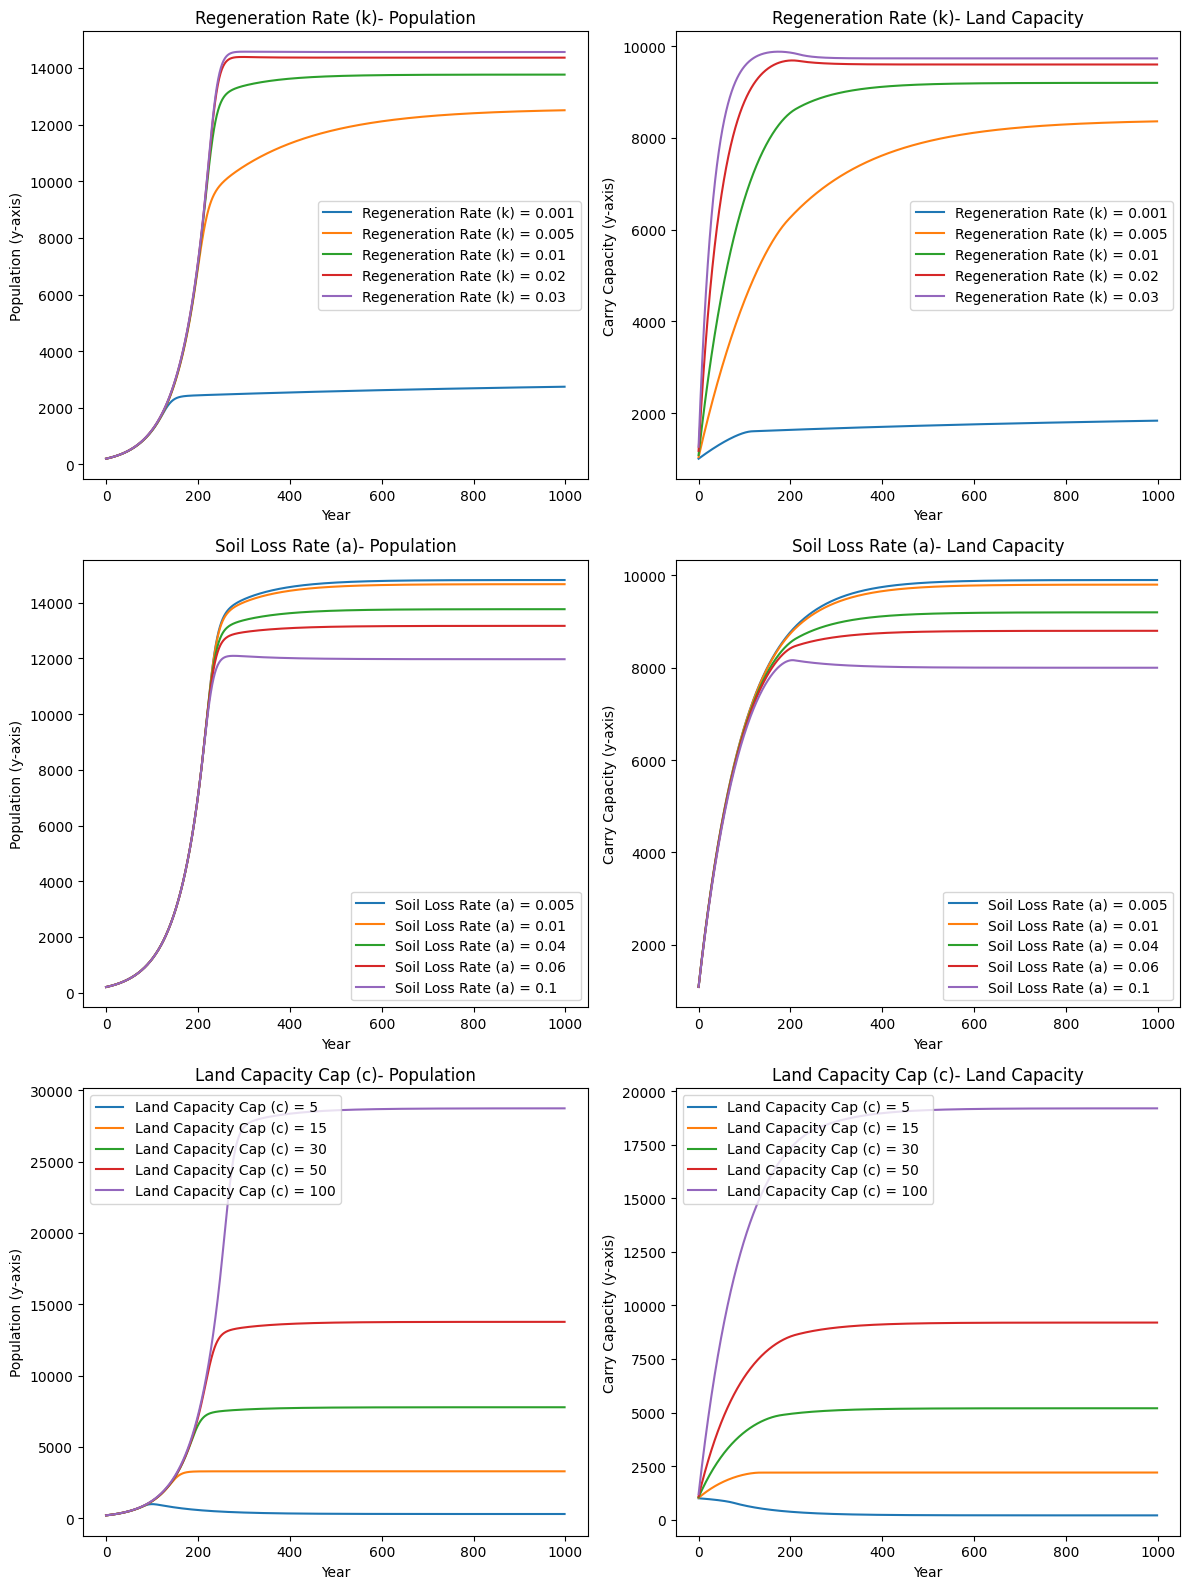

In [104]:
parameters = [('Regeneration Rate (k)', k_range, k_result_pop, k_result_food),
              ('Soil Loss Rate (a)', a_range, a_result_pop, a_result_food),
              ('Land Capacity Cap (c)', c_range, c_result_pop, c_result_food)]

fig, axs = plt.subplots(len(parameters), 2, figsize=(12, 16))

for i, (param_name, param_range, result_pop, result_food) in enumerate(parameters):
    for j in range(len(param_range)):
        axs[i, 0].plot(result_pop[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 0].set_xlabel('Year')
    axs[i, 0].set_ylabel('Population (y-axis)')
    axs[i, 0].set_title(param_name + "- Population")
    axs[i, 0].legend()

    for j in range(len(param_range)):
        axs[i, 1].plot(result_food[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 1].set_xlabel('Year')
    axs[i, 1].set_ylabel('Carry Capacity (y-axis)')
    axs[i, 1].set_title(param_name + "- Land Capacity")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


#### **Solution 2: solve conflict between logistic population growth and the find _top land function by allowing all lands to be utilized.**




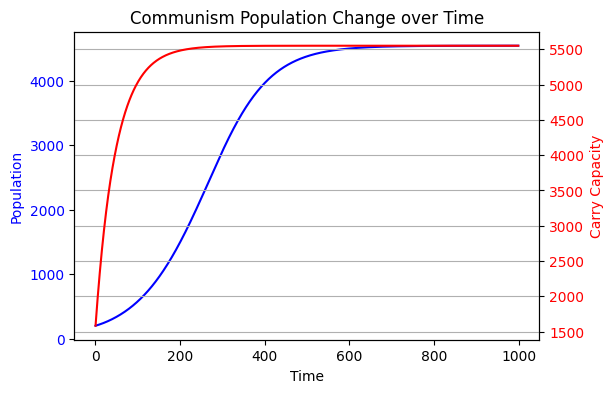

In [93]:
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land):
    populations = [initial_population]  # store population values over time
    P_values = [[0] * initial_population for _ in range(simulation_time)] # total harvest/capacity a year in the village
    u_values = [[0] * initial_population for _ in range(simulation_time)] # using land or not decision
    L_values = [initial_capacity for _ in range(initial_lands)] 
    K_values = [] # land carry capacity  
    Q_values = []

    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): # here I changed to loop over number of lands instead of number of populations.
                land_assignments[0][i] = { #i is from 0 to initial_population - 1. At this moment, initial population == land numbers
                    'landlord': None, 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }
                if i <= initial_population: land_assignments[0][i]['landlord'] = i

    K_t = [land_assignments[0][i]['carry_capacity'] for i in range(initial_lands)] 

    ### Farming Process
        ### Define the function
    def find_top_lands(K_t, populations): #modified part, here is not the top lands, instead, all lands are utilized based on a descending order, aka, everyone farm.
        sorted_lands = sorted(enumerate(K_t), key=lambda x: x[1], reverse=True)
                
        if len(sorted_lands) > populations[-1]:
            sorted_lands = sorted_lands[:int(populations[-1])] ####corrected
        else: pass
        return sorted_lands

    ### Updating process
        
    for t in range(1, simulation_time): # time 0 is already updated.
        K_t = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.
        selected_lands = [x[0] for x in find_top_lands(K_t, populations)]
        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): 
                land_assignments[t][i] = {
                    'landlord': land_assignments[0][i]['landlord'],
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }
                
        for i in selected_lands: land_assignments[t][i]['usage'] = 1 # updated the searching algorithm.

        N_t = populations[-1]  # Get the population value at the previous time step. For the first year, it's the initial_population variable.
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        
        K_t_sum = sum(K_t) # the land carry capacity of the whole village
        P = sum([a*b for a,b in zip(K_t, u_t)]) # the harvest capacity of the whole village. Only consider the selected lands (aka, the top lands).
        if N_t / P > 2: Q = 2 # Q is a factor to slow down the population death rate
        elif N_t / P < 0.5: Q = 0.5
        else: Q = N_t / P
        N_t_plus_1 = N_t + r * N_t * (1 - N_t / P) - d * N_t * Q #### update the total population # the total population of the new year (this year is the new year)
        K_star_t = max_capacity_one_land # the upper limit of each land cell capacity

    #         updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * u_t[i-1]))
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)

        # Append the new values to the respective lists
        populations.append(N_t_plus_1)
        K_values.append(sum(K_t_plus_1)) # total land capacity
        P_values[t-1] = P # update the total harvest capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
        Q_values.append(Q)

    populations = populations[1:] # exclude the zero year population 

    return populations, K_values, P_values, u_values, Q_values, land_assignments

def plot_commuism_simulation_population2(r, k, a, d, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land):
    
    populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid()
    plt.title('Communism Population Change over Time')
    plt.show()


r = 0.0135 # population birth rate
k = 0.02 # land recovery rate 
a = 0.03 # land deplation rate
d = 0.003
simulation_time = 1000 #simulation year
initial_population = 200
initial_capacity = 5
initial_lands = 300
max_capacity_one_land = 20
plot_commuism_simulation_population2(r, k, a, d, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)

In [19]:

r_range = [0.01, 0.04, 0.07, 0.1, 0.2]
k_range = [0.001, 0.005, 0.01, 0.02, 0.03]
d_range = [0.0005, 0.001, 0.002, 0.003, 0.005]
a_range = [0.005, 0.01, 0.04, 0.06, 0.1]
c_range = [5, 15, 30, 50, 100]

baseline_r = 0.04  # Select a baseline value for r
baseline_k = 0.01  # Select a baseline value for k
baseline_d = 0.001  # Select a baseline value for d
baseline_a = 0.04  # Select a baseline value for a
baseline_c = 50  # Select a baseline value for c

# Vary r while keeping other parameters constant ##
r_result_pop = []
r_result_food = []
for r in r_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(r, baseline_k, baseline_d, baseline_a, initial_population, initial_lands, initial_capacity, simulation_time, baseline_c)
    # communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)
    
    r_result_pop.append(result)
    r_result_food.append(cap)
# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, k, baseline_d, baseline_a, initial_population, initial_lands, initial_capacity, simulation_time, baseline_c)
    k_result_pop.append(result)
    k_result_food.append(cap)
# Vary d while keeping other parameters constant
d_result_pop = []
d_result_food = []
for d in d_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, d, baseline_a, initial_population, initial_lands, initial_capacity, simulation_time, baseline_c)
    d_result_pop.append(result)
    d_result_food.append(cap)

# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, baseline_d, a, initial_population, initial_lands, initial_capacity, simulation_time, baseline_c)
    a_result_pop.append(result)
    a_result_food.append(cap)
# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _, _ = communism_simulation_population_original(baseline_r, baseline_k, baseline_d, baseline_a, initial_population, initial_lands, initial_capacity,simulation_time, c)
    c_result_pop.append(result)
    c_result_food.append(cap)

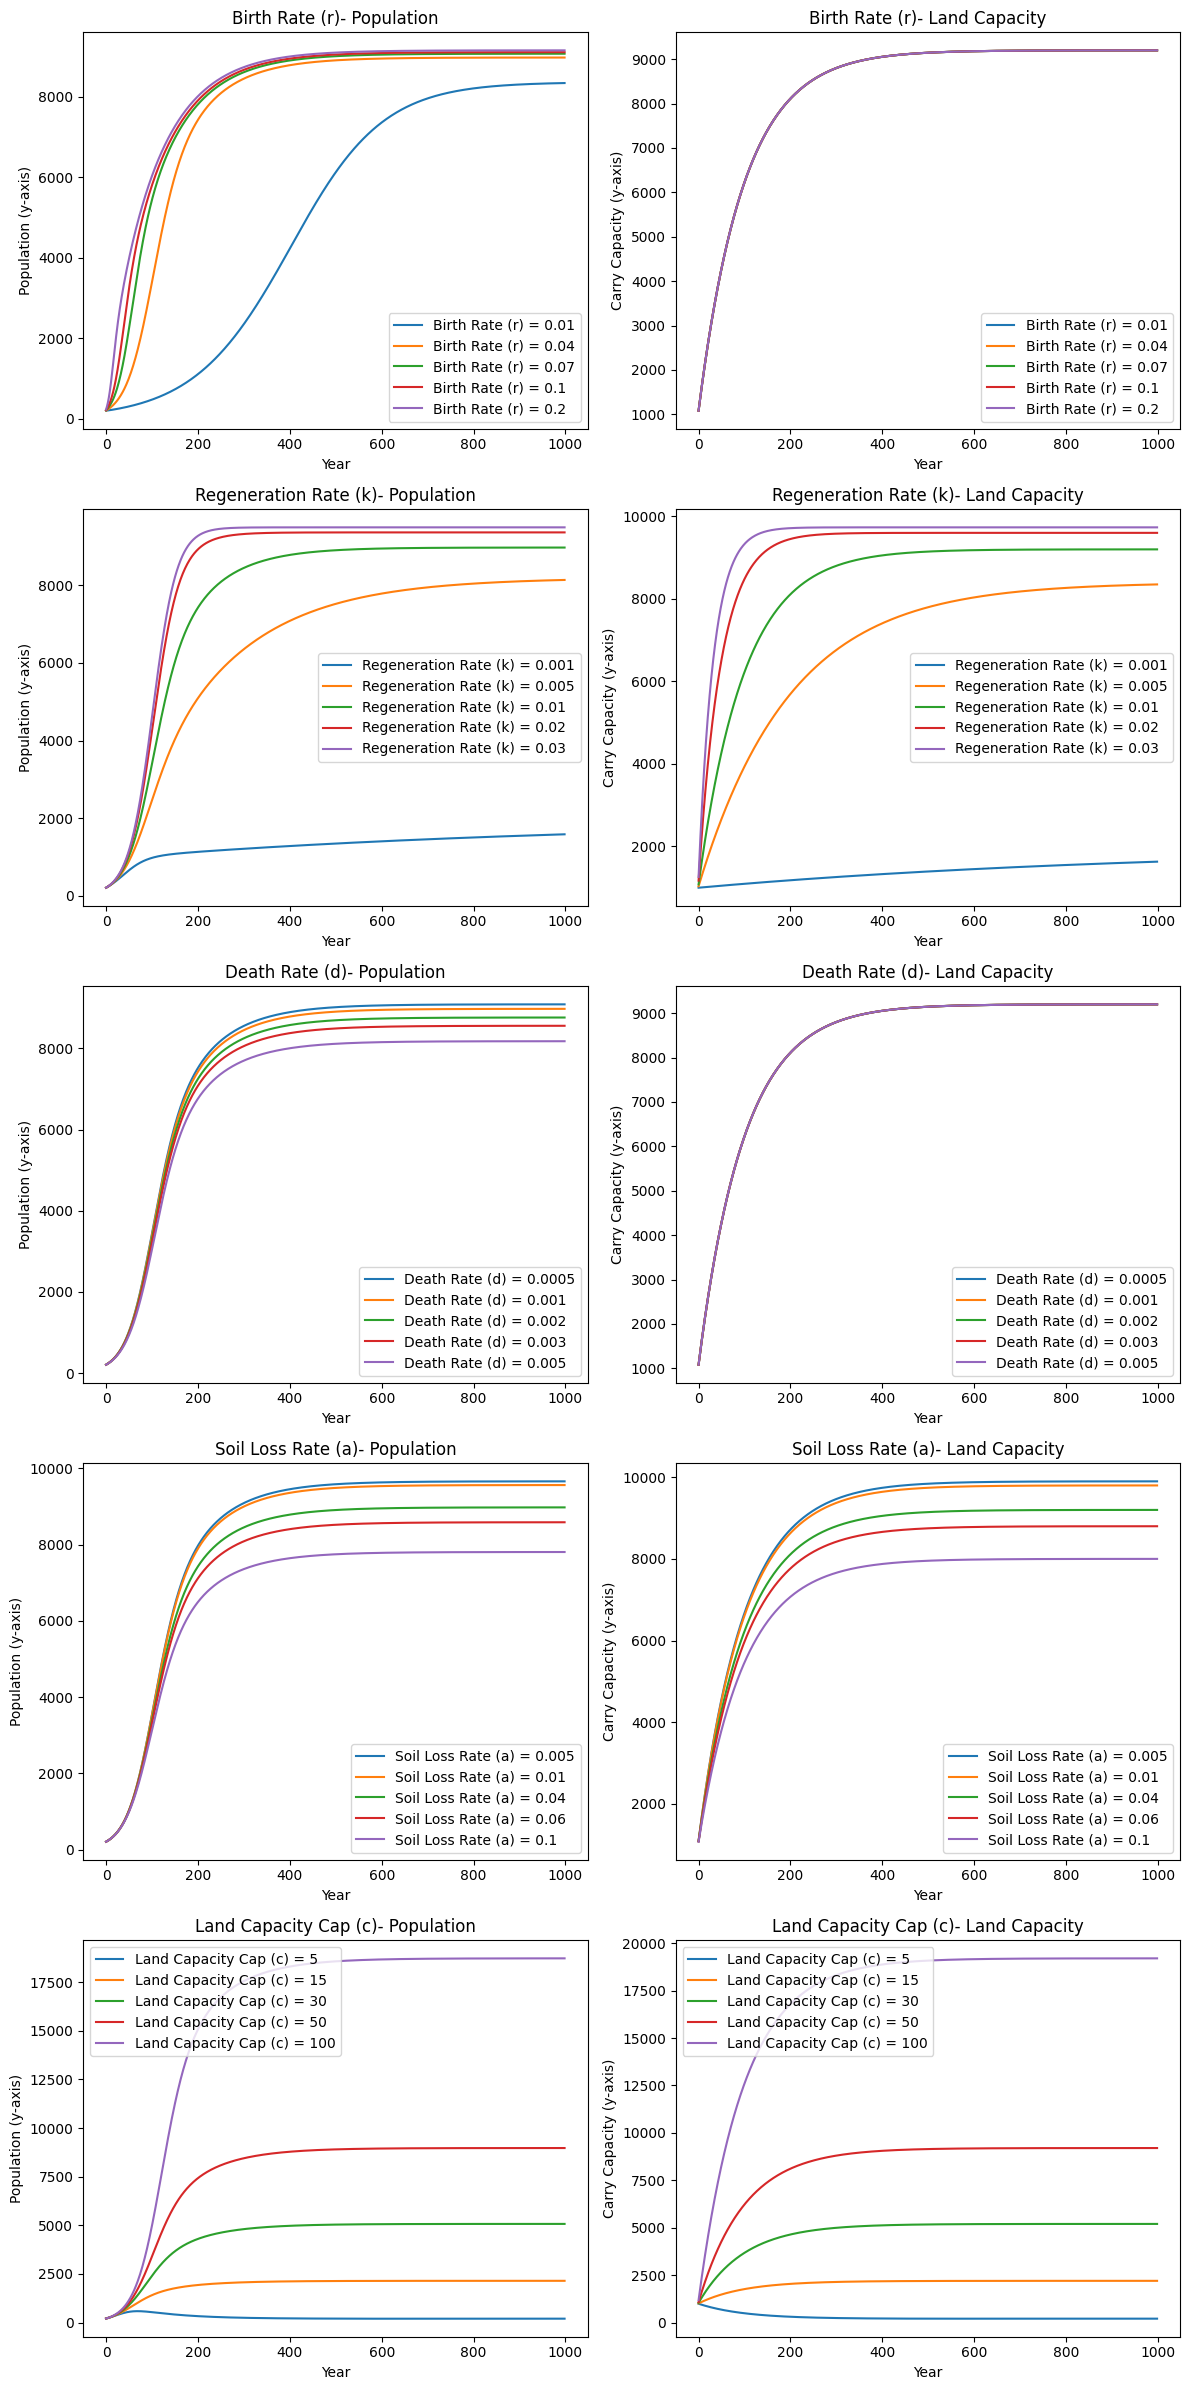

In [20]:
parameters = [('Birth Rate (r)', r_range, r_result_pop, r_result_food),
              ('Regeneration Rate (k)', k_range, k_result_pop, k_result_food),
              ('Death Rate (d)', d_range, d_result_pop, d_result_food),
              ('Soil Loss Rate (a)', a_range, a_result_pop, a_result_food),
              ('Land Capacity Cap (c)', c_range, c_result_pop, c_result_food)]

fig, axs = plt.subplots(len(parameters), 2, figsize=(12, 24))

for i, (param_name, param_range, result_pop, result_food) in enumerate(parameters):
    for j in range(len(param_range)):
        axs[i, 0].plot(result_pop[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 0].set_xlabel('Year')
    axs[i, 0].set_ylabel('Population (y-axis)')
    axs[i, 0].set_title(param_name + "- Population")
    axs[i, 0].legend()

    for j in range(len(param_range)):
        axs[i, 1].plot(result_food[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 1].set_xlabel('Year')
    axs[i, 1].set_ylabel('Carry Capacity (y-axis)')
    axs[i, 1].set_title(param_name + "- Land Capacity")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


In [94]:


# Your simulation data
populations, K, _, _, _, data = communism_simulation_population_original(r, k, d, a, initial_population, initial_lands, initial_capacity, simulation_time, max_capacity_one_land)

# Define the dimension of the grid
grid_dim = int(np.sqrt(max(data[0].keys())))

# Create a colormap
cmap = plt.get_cmap('RdYlBu')

# Function to render the animation for a given year
def render_animation(year):
    # Get the data for the current year
    year_data = data.get(year, {})

    # Create an image with a white background
    image = Image.new('RGBA', (grid_dim * 100, grid_dim * 100), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    if year_data:
        # Iterate over each land cell for the current year
        for land_number, land_data in sorted(year_data.items()):
            carry_capacity = land_data.get('carry_capacity', 0)
            # Map the carry_capacity to a color
            color = cmap(carry_capacity / max_capacity_one_land)

            # Calculate the position of the land cell
            x = (land_number % grid_dim) * 100
            y = (land_number // grid_dim) * 100

            # Draw a rectangle representing the land cell
            draw.rectangle([(x, y), (x + 100, y + 100)], fill=(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)))

            # Add the carry capacity as text
            draw.text((x + 10, y + 30), f'{carry_capacity}', fill='black')

    return image

# Create a list to store the animation frames
animation_frames = []

# Iterate over each year and generate frames
for year in range(max(data.keys()) + 1):
    image = render_animation(year)
    animation_frames.append(image)
    
animation_frames[0].save('animation2.gif', format='GIF', append_images=animation_frames[1:], save_all=True, duration=200, loop=0, optimize=True)
display(widgets.Image(value=open('animation2.gif', 'rb').read()))

Image(value=b'GIF89a\xa4\x06\xa4\x06\x87\x00\x00\xf8\x8eR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\…